In [277]:
#https://medium.com/datawiz-th/%E0%B8%A1%E0%B8%B2%E0%B8%A5%E0%B8%AD%E0%B8%87-forecast-%E0%B8%A3%E0%B8%B2%E0%B8%84%E0%B8%B2%E0%B8%AB%E0%B8%B8%E0%B9%89%E0%B8%99%E0%B9%81%E0%B8%9A%E0%B8%9A%E0%B8%87%E0%B9%88%E0%B8%B2%E0%B8%A2%E0%B9%86-%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2-deep-learning-lstm-python-305c480db223
#https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
import pandas as pd
import numpy as np 

In [278]:
df = pd.read_csv('owid-covid-data.csv', usecols=[2,3,4,5,7], engine='python')
df

,location,date,total_cases,new_cases,total_deaths
0,Afghanistan,2020-02-24,5.0,5.0,NaN
1,Afghanistan,2020-02-25,5.0,0.0,NaN
2,Afghanistan,2020-02-26,5.0,0.0,NaN
3,Afghanistan,2020-02-27,5.0,0.0,NaN
4,Afghanistan,2020-02-28,5.0,0.0,NaN
...,...,...,...,...,...
167703,Zimbabwe,2022-03-07,239710.0,501.0,5399.0
167704,Zimbabwe,2022-03-08,240343.0,633.0,5400.0
167705,Zimbabwe,2022-03-09,240343.0,0.0,5400.0
167706,Zimbabwe,2022-03-10,241548.0,1205.0,5408.0


In [279]:
th = df.loc[df['location'].isin(['Thailand'])].dropna() #.set_index('date')
th.tail(5)

,location,date,total_cases,new_cases,total_deaths
150346,Thailand,2022-03-07,3066800.0,18943.0,23369.0
150347,Thailand,2022-03-08,3088873.0,22073.0,23438.0
150348,Thailand,2022-03-09,3111857.0,22984.0,23512.0
150349,Thailand,2022-03-10,3136649.0,24792.0,23575.0
150350,Thailand,2022-03-11,3161241.0,24592.0,23643.0


In [280]:
m = th[th.new_cases == 0].reset_index()
m

,index,location,date,total_cases,new_cases,total_deaths
0,149610,Thailand,2020-03-01,42.0,0.0,1.0
1,149612,Thailand,2020-03-03,43.0,0.0,1.0
2,149613,Thailand,2020-03-04,43.0,0.0,1.0
3,149617,Thailand,2020-03-08,50.0,0.0,1.0
4,149618,Thailand,2020-03-09,50.0,0.0,1.0
5,149683,Thailand,2020-05-13,3017.0,0.0,56.0
6,149686,Thailand,2020-05-16,3025.0,0.0,56.0
7,149692,Thailand,2020-05-22,3037.0,0.0,56.0
8,149694,Thailand,2020-05-24,3040.0,0.0,56.0
9,149712,Thailand,2020-06-11,3125.0,0.0,58.0


In [281]:
missing_zero = m.new_cases[m.new_cases == 0].count()
print('missing_zero = {}'.format(missing_zero))
print('{:.2f} %'.format(missing_zero / th.shape[0] * 100))

missing_zero = 25
3.38 %


In [282]:
#ในกรณีที่พบ 0 ไม่มาก คือไม่กี่ % ไม่ต้องตัดออกให้ใช้วิธีเติมค่าเฉลี่ย
th['newcases'] = th.new_cases.replace(0, th.new_cases.mean())
#dm = th.to_csv('ThaiCovid.csv')

In [283]:
stock_data = pd.read_csv('ThaiCovid.csv', usecols=[3,5,6], engine='python')
stock_data.tail(5)

,total_cases,total_deaths,newcases
735,3066800.0,23369.0,18943.0
736,3088873.0,23438.0,22073.0
737,3111857.0,23512.0,22984.0
738,3136649.0,23575.0,24792.0
739,3161241.0,23643.0,24592.0


In [284]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_cases   740 non-null    float64
 1   total_deaths  740 non-null    float64
 2   newcases      740 non-null    float64
dtypes: float64(3)
memory usage: 17.5 KB


In [285]:
# function สำหรับ preprocessing ข้อมูล time series หลายตัวแปร

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [286]:
dataset = stock_data
values = dataset.values
values = values.astype('float32')

In [287]:
# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())

In [288]:
# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
# reframed.drop(['High(t)','High(t+1)','High(t+2)','Low(t)','Low(t+1)','Low(t+2)','Open(t)','Open(t+1)','Open(t+2)','Volume(t)','Volume(t+1)',\
#                'Volume(t+2)'],axis=1,inplace=True)

reframed = series_to_supervised(dataset.values, 365, 30,feat_name=stock_data.columns)
reframed.head(5)

,total_cases(t-365),total_deaths(t-365),newcases(t-365),total_cases(t-364),total_deaths(t-364),newcases(t-364),total_cases(t-363),total_deaths(t-363),newcases(t-363),total_cases(t-362),total_deaths(t-362),newcases(t-362),total_cases(t-361),total_deaths(t-361),newcases(t-361),total_cases(t-360),total_deaths(t-360),newcases(t-360),total_cases(t-359),total_deaths(t-359),newcases(t-359),total_cases(t-358),total_deaths(t-358),newcases(t-358),total_cases(t-357),total_deaths(t-357),newcases(t-357),total_cases(t-356),total_deaths(t-356),newcases(t-356),total_cases(t-355),total_deaths(t-355),newcases(t-355),total_cases(t-354),total_deaths(t-354),newcases(t-354),total_cases(t-353),total_deaths(t-353),newcases(t-353),total_cases(t-352),total_deaths(t-352),newcases(t-352),total_cases(t-351),total_deaths(t-351),newcases(t-351),total_cases(t-350),total_deaths(t-350),newcases(t-350),total_cases(t-349),total_deaths(t-349),newcases(t-349),total_cases(t-348),total_deaths(t-348),newcases(t-348),total_cases(t-347),total_deaths(t-347),newcases(t-347),total_cases(t-346),total_deaths(t-346),newcases(t-346),total_cases(t-345),total_deaths(t-345),newcases(t-345),total_cases(t-344),total_deaths(t-344),newcases(t-344),total_cases(t-343),total_deaths(t-343),newcases(t-343),total_cases(t-342),total_deaths(t-342),newcases(t-342),total_cases(t-341),total_deaths(t-341),newcases(t-341),total_cases(t-340),total_deaths(t-340),newcases(t-340),total_cases(t-339),total_deaths(t-339),newcases(t-339),total_cases(t-338),total_deaths(t-338),newcases(t-338),total_cases(t-337),total_deaths(t-337),newcases(t-337),total_cases(t-336),total_deaths(t-336),newcases(t-336),total_cases(t-335),total_deaths(t-335),newcases(t-335),total_cases(t-334),total_deaths(t-334),newcases(t-334),total_cases(t-333),total_deaths(t-333),newcases(t-333),total_cases(t-332),total_deaths(t-332),newcases(t-332),total_cases(t-331),total_deaths(t-331),newcases(t-331),total_cases(t-330),total_deaths(t-330),newcases(t-330),total_cases(t-329),total_deaths(t-329),newcases(t-329),total_cases(t-328),total_deaths(t-328),newcases(t-328),total_cases(t-327),total_deaths(t-327),newcases(t-327),total_cases(t-326),total_deaths(t-326),newcases(t-326),total_cases(t-325),total_deaths(t-325),newcases(t-325),total_cases(t-324),total_deaths(t-324),newcases(t-324),total_cases(t-323),total_deaths(t-323),newcases(t-323),total_cases(t-322),total_deaths(t-322),newcases(t-322),total_cases(t-321),total_deaths(t-321),newcases(t-321),total_cases(t-320),total_deaths(t-320),newcases(t-320),total_cases(t-319),total_deaths(t-319),newcases(t-319),total_cases(t-318),total_deaths(t-318),newcases(t-318),total_cases(t-317),total_deaths(t-317),newcases(t-317),total_cases(t-316),total_deaths(t-316),newcases(t-316),total_cases(t-315),total_deaths(t-315),newcases(t-315),total_cases(t-314),total_deaths(t-314),newcases(t-314),total_cases(t-313),total_deaths(t-313),newcases(t-313),total_cases(t-312),total_deaths(t-312),newcases(t-312),total_cases(t-311),total_deaths(t-311),newcases(t-311),total_cases(t-310),total_deaths(t-310),newcases(t-310),total_cases(t-309),total_deaths(t-309),newcases(t-309),total_cases(t-308),total_deaths(t-308),newcases(t-308),total_cases(t-307),total_deaths(t-307),newcases(t-307),total_cases(t-306),total_deaths(t-306),newcases(t-306),total_cases(t-305),total_deaths(t-305),newcases(t-305),total_cases(t-304),total_deaths(t-304),newcases(t-304),total_cases(t-303),total_deaths(t-303),newcases(t-303),total_cases(t-302),total_deaths(t-302),newcases(t-302),total_cases(t-301),total_deaths(t-301),newcases(t-301),total_cases(t-300),total_deaths(t-300),newcases(t-300),total_cases(t-299),total_deaths(t-299),newcases(t-299),total_cases(t-298),total_deaths(t-298),newcases(t-298),total_cases(t-297),total_deaths(t-297),newcases(t-297),total_cases(t-296),total_deaths(t-296),newcases(t-296),total_cases(t-295),total_deaths(t-295),newcases(t-295),total_cases(t-294),total_deaths(t-294),newcases(t-294),total_cases(t-293),total_deaths(t-293),

In [289]:
# ทำ train & test split
values = reframed.values
n_train_percent = 0.9
split = int(values.shape[0]*0.9)
train = values[:split, :]
test = values[split:, :]

In [290]:
trainData = pd.DataFrame(train)#.round(0)
trainData.tail(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,...,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,117

In [291]:
testData = pd.DataFrame(test) 
testData.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,...,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,117

In [292]:
# เก็บค่า datetime ของ train & test
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:split]
date_test = date_reframed[split:]

In [293]:
# split feature และ target
train_X, train_y = train[:, :-3], train[:, -3:]
test_X, test_y = test[:, :-3], test[:, -3:]

In [294]:
# reshape input ให้เป็น 3D (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [295]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# สร้าง LSTM network ด้วย library Keras โดยกำหนดขนาด hidden layer(50) และ shape ของข้อมูล input(#rows x #features)
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# สร้าง hidden layer ตามขนาด output หรือ จำนวนวันที่ต้องการ forecast (3) 
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                246600    
                                                                 
 dense_8 (Dense)             (None, 3)                 153       
                                                                 
Total params: 246,753
Trainable params: 246,753
Non-trainable params: 0
_________________________________________________________________


In [296]:
# train โมเดล และเก็บ log
history = model.fit(train_X, train_y, epochs=100, batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/100
5/5 [==============================] - 2s 95ms/step - loss: 0.1885 - val_loss: 0.2197
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.1332 - val_loss: 0.3737
Epoch 3/100
5/5 [==============================] - 0s 37ms/step - loss: 0.0755 - val_loss: 0.2912
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.1041 - val_loss: 0.1685
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0625 - val_loss: 0.2204
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0489 - val_loss: 0.1642
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0508 - val_loss: 0.1175
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0441 - val_loss: 0.1327
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0290 - val_loss: 0.0997
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.1524
Epoch 11/100
5/5 [=======

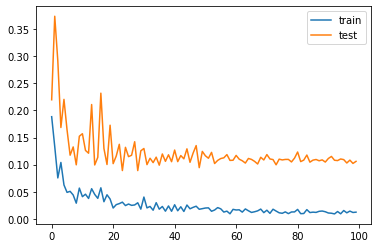

In [297]:
# พล็อตค่า train&test loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [298]:
# ทำ prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [299]:
# rescale ข้อมูลกลับ
inv_yhat = yhat*(max_dict['total_cases']-min_dict['total_cases'])+min_dict['total_cases']
inv_y = test_y*(max_dict['total_cases']-min_dict['total_cases'])+min_dict['total_cases']

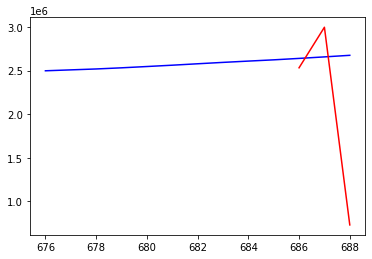

In [300]:
# พล็อตราคาจริงของวันที่ทำ prediction ล่วงหน้า 3 วัน + ราคาย้อนหลัง 30 วัน (สีน้ำเงิน) และ ราคา forecast (สีแดง)
import numpy as np
idx = np.random.randint(0,len(yhat-3))
if idx <30:
  date_actual = date_test[:idx+3]
else:
  date_actual = date_test[idx-30:idx+3]
_=pyplot.plot(date_actual,inv_y[max(0,idx-30):idx+3,0],'b')
_=pyplot.plot(date_test[idx:idx+3],inv_yhat[idx],'r')

In [305]:
actual = pd.DataFrame(inv_y).round(0)
actual

,0,1,2
0,2497001.0,2980464.0,806958.0
1,2507471.0,2982068.0,776619.0
2,2517869.0,2984341.0,771278.0
3,2531051.0,2987550.0,977791.0
4,2545873.0,2990224.0,1099444.0
5,2561115.0,2993300.0,1130599.0
6,2577445.0,2996643.0,1211306.0
7,2593327.0,2999852.0,1178074.0
8,2608227.0,3003328.0,1105230.0
9,2622600.0,3006938.0,1066138.0


In [302]:
3161241.0

3161241.0

In [306]:
pred = pd.DataFrame(inv_yhat).round(0)
pred  

,0,1,2
0,2478513.0,2962592.0,676086.0
1,2489846.0,2969409.0,682740.0
2,2490650.0,2970283.0,684136.0
3,2500331.0,2979815.0,694147.0
4,2503946.0,2979678.0,702462.0
5,2507672.0,2981894.0,707691.0
6,2513912.0,2987278.0,715030.0
7,2517418.0,2987520.0,717414.0
8,2523706.0,2990776.0,721172.0
9,2529281.0,2994175.0,723866.0
